# Import Data

In [ ]:
# Get Dataset
#Kaggle: https://www.kaggle.com/datasets/shivamb/go-emotions-google-emotions-dataset

!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [1]:
!nvidia-smi

Thu Apr  6 18:02:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti    WDDM | 00000000:29:00.0  On |                  N/A |
| 30%   37C    P0               42W / 200W|    403MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessor
import contractions
import json
import re
from collections import OrderedDict
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()

In [2]:
DATA_PATH = 'data/full_dataset/goemotions_'
OUTPUT_DIR = 'training_data'

df1 = pd.read_csv(f'{DATA_PATH}1.csv')
df2 = pd.read_csv(f'{DATA_PATH}2.csv')
df3 = pd.read_csv(f'{DATA_PATH}3.csv')

frames = [df1,df2,df3]

df = pd.concat(frames)

df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


# Preprocess Data

In [3]:
# FROM: https://www.kaggle.com/code/esknight/emotion-classification-final
# Function for cleaning text
def clean_text(text):
    re_number = re.compile('[0-9]+')
    re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
    re_tag = re.compile('\[[A-Z]+\]')
    re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
    re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
    re_punc = re.compile('[?!,.\'\"]')
  
    text = re.sub(re_char, "", text) # Remove unknown character 
    text = contractions.fix(text) # Expand contraction
    text = re.sub(re_url, ' [url] ', text) # Replace URL with number
    text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
    #text = re.sub(re_punc, "", text) # Remove punctuation.
    text = text.lower() # Lower text
    text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

    return text

In [4]:
# Clean text
df['clean_text'] = df['text'].progress_apply(clean_text)

# Drop Useless Columns
df = df.drop(columns=['id','example_very_unclear','author','subreddit','link_id','parent_id','created_utc','rater_id'])

# Reorganize Columns
df = df[['clean_text'] + [col for col in df.columns if col not in ['text','clean_text']]]

  0%|          | 0/211225 [00:00<?, ?it/s]

In [5]:
#View emotions easier
emotions = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
emotions

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [6]:
id2label = {str(i):label for i, label in enumerate(emotions)}
label2id = {label:str(i) for i, label in enumerate(emotions)}

In [7]:
print(id2label)
print(label2id)

{'0': 'admiration', '1': 'amusement', '2': 'anger', '3': 'annoyance', '4': 'approval', '5': 'caring', '6': 'confusion', '7': 'curiosity', '8': 'desire', '9': 'disappointment', '10': 'disapproval', '11': 'disgust', '12': 'embarrassment', '13': 'excitement', '14': 'fear', '15': 'gratitude', '16': 'grief', '17': 'joy', '18': 'love', '19': 'nervousness', '20': 'optimism', '21': 'pride', '22': 'realization', '23': 'relief', '24': 'remorse', '25': 'sadness', '26': 'surprise', '27': 'neutral'}
{'admiration': '0', 'amusement': '1', 'anger': '2', 'annoyance': '3', 'approval': '4', 'caring': '5', 'confusion': '6', 'curiosity': '7', 'desire': '8', 'disappointment': '9', 'disapproval': '10', 'disgust': '11', 'embarrassment': '12', 'excitement': '13', 'fear': '14', 'gratitude': '15', 'grief': '16', 'joy': '17', 'love': '18', 'nervousness': '19', 'optimism': '20', 'pride': '21', 'realization': '22', 'relief': '23', 'remorse': '24', 'sadness': '25', 'surprise': '26', 'neutral': '27'}


In [8]:
# One-Hot Encoding all Emotions
df["labels"] = df[emotions].values.tolist()
df.head()

,clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,labels
0,that game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,sexuality should not be a grouping category i...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"you do right, if you do not care then fuck them!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,man i love reddit.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"name was nowhere near them, he was by the falc...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
# create train / test splits
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

(df_train.shape, df_test.shape)

((168937, 30), (42288, 30))

# Data Visualization

In [ ]:
# Emotions Visualization by number of cases

temp = df[list(emotions)].sum(axis=0) \
    .reset_index() \
    .rename(columns={'index': 'emotion', 0: 'n'}) \
    .sort_values('n', ascending=False)

fig, ax = plt.subplots(figsize=(7, 7))
ax.tick_params(axis='x', rotation=90)
sns.barplot(data=temp, x='n', 
            y='emotion',
            dodge=False,
            ax=ax).set_title('Emotions by number of appearances')

In [ ]:
# Concatenating emotions

pos = {'admiration','amusement','approval','caring','desire','excitement','gratitude','joy','love',
       'optimism','pride','relief'}
neg = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness',
       'remorse','grief','disgust'}
amb= {'realization','surprise','curiosity','confusion','neutral'}

In [ ]:
# Emotions and data vis

print("Length of data: ", len(df))
print("Number of emotions: ", len(emotions))
print("Number of positive emotions: ", len(pos))
print("Number of negative emotions: ", len(neg))
print("Number of ambiguous emotions: ", len(amb))

In [ ]:
# Emotions dataframe to later on aggregate

df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = ''
df_emotion['group'].loc[df_emotion['emotion'].isin(pos)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(neg)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(amb)] = 'ambiguous'

In [ ]:
df_emotion.head()

In [ ]:
# Emotions by number of appearences but by group

temp = pd.DataFrame()
temp['true positive rate'] = df.iloc[:, 3:-1].mean(0)
temp['emotion'] = df.columns[3:-1]
temp = temp.merge(df_emotion, how='left', on='emotion')
temp = temp.sort_values('true positive rate')

fig, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='x', rotation=90)

sns.barplot(x=temp['emotion'], 
            y=temp['true positive rate'], 
            hue=temp['group'], 
            dodge=False)

In [ ]:
def represent_train_test_balance(train_df,test_df):
    # Class representation for train/test DS
    train_GO = (train_df.loc[:,list(emotions)].sum(axis=0) / len(train_df)) * 100
    test_GO = (test_df.loc[:,list(emotions)].sum(axis=0) / len(test_df)) * 100
    
    # Unique dataset for visualization purposes
    
    ds_GO = pd.DataFrame(data=[train_GO, test_GO]).T.reset_index(drop=False)
    ds_GO.columns = ['Emotion', 'Train','Test']
    ds_GO = ds_GO.sort_values('Train',ascending=False)
    ds_GO = ds_GO.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Test'],
                      value_name='Percentage')
    
    # Display dataset
    
    display(ds_GO.head(10))
    
    print("Graph Visualization")
    
    plt.figure(figsize=(20,15))
    sns.barplot(x='Percentage', y='Emotion', data=ds_GO, orient='h', hue='Dataset')
    plt.title('Percentage of samples per emotion in train and test datasets', fontweight='bold', fontsize=20)
    plt.xlabel('Percentage of all samples', fontweight='bold', fontsize=16)
    plt.ylabel('Emotions', fontweight='bold', fontsize= 16)
    plt.show()
represent_train_test_balance(df_train, df_test)

# Tokenization / Encoding / Method Structuring

In [32]:
# Imports
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification, XLNetForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.xlnet.modeling_xlnet import XLNetForSequenceClassificationOutput
from torch import nn
import random
import torch
import platform
import sys
import sklearn as sk
from typing import Optional, Union, Tuple


In [17]:
MAX_LEN = 256

In [53]:
class GoEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
def train_test(df_train, df_test, tokenizer): 
  # Encodings

  train_encodings = tokenizer(df_train["clean_text"].values.tolist(), truncation=True)
  test_encodings = tokenizer(df_test["clean_text"].values.tolist(), truncation=True)

  # labels / output
  train_emotions = df_train["labels"].values.tolist()
  test_emotions = df_test["labels"].values.tolist()

  train_dataset = GoEmotionDataset(train_encodings, train_emotions)
  test_dataset = GoEmotionDataset(test_encodings, test_emotions)
  return train_dataset, test_dataset
  
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = torch.from_numpy(logits)
    y_true = torch.from_numpy(labels)
    y_pred = y_pred.sigmoid()
    y_pred = y_pred>0.5
    y_true = y_true.bool()
    acc = (y_pred==y_true).float().mean().item()

    return {       
      'Accuracy': acc
    }
    
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=False
    torch.backends.cudnn.benchmark = False
    
def device_to_use():
    has_gpu = torch.cuda.is_available()
    has_mps = getattr(torch,'has_mps',False)
    device = "mps" if getattr(torch,'has_mps',False) \
        else "gpu" if torch.cuda.is_available() else "cpu"

    print(f"Python Platform: {platform.platform()}")
    print(f"PyTorch Version: {torch.__version__}")
    print()
    print(f"Python {sys.version}")
    print(f"Pandas {pd.__version__}")
    print(f"Scikit-Learn {sk.__version__}")
    print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
    print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
    print(f"Target device is {device}")
    return device

def model_train(train_dataset, test_dataset, model, tokenizer, NUM_EPOCHS = 10,batch_size = 16, adam_epsilon_arg = 1e-8, learning_rate_arg = 2e-5, use_mps_device_arg = False, model_name = "default"):
  training_args = TrainingArguments( 
    output_dir= OUTPUT_DIR+"/"+model_name,    
    adam_epsilon = adam_epsilon_arg,
    learning_rate = learning_rate_arg,
    use_mps_device = use_mps_device_arg, # Mac Sylicon GPU
    per_device_train_batch_size = batch_size, 
    per_device_eval_batch_size = batch_size*4,
    gradient_accumulation_steps = 2, # scale batch size without needing more memory
    num_train_epochs= NUM_EPOCHS,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'Accuracy',
    greater_is_better = True,
    weight_decay=0.01,
    seed = 25,
    report_to="none"
  )
  set_seed(training_args.seed)
  trainer = Trainer(
      model = model,
      args = training_args,
      train_dataset = train_dataset,
      eval_dataset=test_dataset,
      compute_metrics=compute_metrics,
      tokenizer=tokenizer
  )
  return training_args, trainer
                                              

In [20]:
# Classes to Each Model

class DistilBertForMultilabelSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + distilbert_output[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions)

class BertForMultilabelSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        bert_output = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = bert_output[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + bert_output[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions)

class RoBertaForMultilabelSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        roberta_output = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = roberta_output[0]
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + roberta_output[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=roberta_output.hidden_states,
            attentions=roberta_output.attentions)

class XLNetForMultilabelSequenceClassification(XLNetForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        mems: Optional[torch.Tensor] = None,
        perm_mask: Optional[torch.Tensor] = None,
        target_mapping: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        input_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        use_mems: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **kwargs,  # delete when `use_cache` is removed in XLNetModel
    ) -> Union[Tuple, XLNetForSequenceClassificationOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        xlnet_output = self.transformer(
            input_ids,
            attention_mask=attention_mask,
            mems=mems,
            perm_mask=perm_mask,
            target_mapping=target_mapping,
            token_type_ids=token_type_ids,
            input_mask=input_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_mems=use_mems,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs)
        output = xlnet_output[0]
        output = self.sequence_summary(output)
        logits = self.logits_proj(output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + xlnet_output[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=xlnet_output.hidden_states,
            attentions=xlnet_output.attentions)

# Pre-Trained Model - DistilBERT

In [27]:
model_path_or_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_path_or_name)
num_labels=len(emotions)
device = device_to_use()
if device == 'gpu': device = 'cuda'
model = DistilBertForMultilabelSequenceClassification.from_pretrained(model_path_or_name, num_labels=num_labels).to(device)
model = model_config_ids(model, id2label, label2id)

Python Platform: Windows-10-10.0.22621-SP0
PyTorch Version: 2.0.0

Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is gpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultilabelSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultilabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": [
    {
      "0": "admiration",
      "1": "amusement",
      "10": "disapproval",
      "11": "disgust",
      "12": "embarrassment",
      "13": "excitement",
      "14": "fear",
      "15": "gratitude",
      "16": "grief",
      "17": "joy",
      "18": "love",
      "19": "nervousness",
      "2": "anger",
      "20": "optimism",
      "21": "pride",
      "22": "realization",
      "23": "relief",
      "24": "remorse",
      "25": "sadness",
      "26": "surprise",
      "27": "neutral",
      "3": "annoyance",
      "4": "approval",
      "5": "caring",
      "6": "confusion",
      "7": "curiosity",
      "8": "desire",
      "9": "disappointment"
    }
  ],
  "initializer_range": 0.02,
  "label2id": {
    "admiration": "0",
    "amusement":

In [28]:
train_dataset, test_dataset = train_test(df_train, df_test, tokenizer)
training_args, trainer = model_train(train_dataset, test_dataset, model, tokenizer, NUM_EPOCHS = 3,batch_size = 16, adam_epsilon_arg = 1e-8, learning_rate_arg = 2e-5, use_mps_device_arg = False, model_name = "distilbert")

In [29]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.697327733039856,
 'eval_Accuracy': 0.46574118733406067,
 'eval_runtime': 22.9739,
 'eval_samples_per_second': 1850.969,
 'eval_steps_per_second': 28.946}

In [18]:
trainer.train()

c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15876 [00:00<?, ?it/s]

{'loss': 0.2038, 'learning_rate': 1.9370118417737468e-05, 'epoch': 0.09}
{'loss': 0.1395, 'learning_rate': 1.874023683547493e-05, 'epoch': 0.19}
{'loss': 0.1276, 'learning_rate': 1.8110355253212397e-05, 'epoch': 0.28}
{'loss': 0.1216, 'learning_rate': 1.7480473670949864e-05, 'epoch': 0.38}
{'loss': 0.1197, 'learning_rate': 1.6850592088687327e-05, 'epoch': 0.47}
{'loss': 0.1191, 'learning_rate': 1.6220710506424793e-05, 'epoch': 0.57}
{'loss': 0.1168, 'learning_rate': 1.559082892416226e-05, 'epoch': 0.66}
{'loss': 0.1168, 'learning_rate': 1.4960947341899723e-05, 'epoch': 0.76}
{'loss': 0.117, 'learning_rate': 1.433106575963719e-05, 'epoch': 0.85}
{'loss': 0.1158, 'learning_rate': 1.3701184177374655e-05, 'epoch': 0.94}


  0%|          | 0/655 [00:00<?, ?it/s]

{'eval_loss': 0.11368750780820847, 'eval_Accuracy': 0.9615535140037537, 'eval_runtime': 23.4143, 'eval_samples_per_second': 1788.137, 'eval_steps_per_second': 27.974, 'epoch': 1.0}
{'loss': 0.1139, 'learning_rate': 1.3071302595112122e-05, 'epoch': 1.04}
{'loss': 0.1115, 'learning_rate': 1.2441421012849586e-05, 'epoch': 1.13}
{'loss': 0.111, 'learning_rate': 1.1811539430587051e-05, 'epoch': 1.23}
{'loss': 0.1112, 'learning_rate': 1.1181657848324516e-05, 'epoch': 1.32}
{'loss': 0.1116, 'learning_rate': 1.0551776266061982e-05, 'epoch': 1.42}
{'loss': 0.111, 'learning_rate': 9.921894683799447e-06, 'epoch': 1.51}
{'loss': 0.1113, 'learning_rate': 9.292013101536911e-06, 'epoch': 1.61}
{'loss': 0.111, 'learning_rate': 8.662131519274378e-06, 'epoch': 1.7}
{'loss': 0.1101, 'learning_rate': 8.032249937011843e-06, 'epoch': 1.79}
{'loss': 0.111, 'learning_rate': 7.402368354749307e-06, 'epoch': 1.89}
{'loss': 0.1094, 'learning_rate': 6.772486772486773e-06, 'epoch': 1.98}


  0%|          | 0/655 [00:00<?, ?it/s]

{'eval_loss': 0.11142463237047195, 'eval_Accuracy': 0.9618861675262451, 'eval_runtime': 22.0921, 'eval_samples_per_second': 1895.156, 'eval_steps_per_second': 29.649, 'epoch': 2.0}
{'loss': 0.1074, 'learning_rate': 6.142605190224238e-06, 'epoch': 2.08}
{'loss': 0.1066, 'learning_rate': 5.512723607961704e-06, 'epoch': 2.17}
{'loss': 0.1066, 'learning_rate': 4.8828420256991685e-06, 'epoch': 2.27}
{'loss': 0.1059, 'learning_rate': 4.252960443436635e-06, 'epoch': 2.36}
{'loss': 0.1063, 'learning_rate': 3.6230788611740995e-06, 'epoch': 2.46}
{'loss': 0.1065, 'learning_rate': 2.993197278911565e-06, 'epoch': 2.55}
{'loss': 0.1058, 'learning_rate': 2.36331569664903e-06, 'epoch': 2.65}
{'loss': 0.1065, 'learning_rate': 1.7334341143864955e-06, 'epoch': 2.74}
{'loss': 0.1054, 'learning_rate': 1.1035525321239608e-06, 'epoch': 2.83}
{'loss': 0.1065, 'learning_rate': 4.736709498614261e-07, 'epoch': 2.93}


  0%|          | 0/655 [00:00<?, ?it/s]

{'eval_loss': 0.11119987070560455, 'eval_Accuracy': 0.9619091749191284, 'eval_runtime': 22.9527, 'eval_samples_per_second': 1824.103, 'eval_steps_per_second': 28.537, 'epoch': 3.0}
{'train_runtime': 1237.3091, 'train_samples_per_second': 410.626, 'train_steps_per_second': 12.831, 'train_loss': 0.11541589485604807, 'epoch': 3.0}


TrainOutput(global_step=15876, training_loss=0.11541589485604807, metrics={'train_runtime': 1237.3091, 'train_samples_per_second': 410.626, 'train_steps_per_second': 12.831, 'train_loss': 0.11541589485604807, 'epoch': 3.0})

# Pre-Trained Model - BERT

In [30]:
model_path_or_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path_or_name)
num_labels=len(emotions)
device = device_to_use()
if device == 'gpu': device = 'cuda'
model = BertForMultilabelSequenceClassification.from_pretrained(model_path_or_name, num_labels=num_labels).to(device)
model = model_config_ids(model, id2label, label2id)

Python Platform: Windows-10-10.0.22621-SP0
PyTorch Version: 2.0.0

Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is gpu


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultilabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultilabelSequenceClassification were not 

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": [
    {
      "0": "admiration",
      "1": "amusement",
      "10": "disapproval",
      "11": "disgust",
      "12": "embarrassment",
      "13": "excitement",
      "14": "fear",
      "15": "gratitude",
      "16": "grief",
      "17": "joy",
      "18": "love",
      "19": "nervousness",
      "2": "anger",
      "20": "optimism",
      "21": "pride",
      "22": "realization",
      "23": "relief",
      "24": "remorse",
      "25": "sadness",
      "26": "surprise",
      "27": "neutral",
      "3": "annoyance",
      "4": "approval",
      "5": "caring",
      "6": "confusion",
      "7": "curiosity",
      "8": "desire",
      "9": "disappointment"
    }
  ],
  "initializer_range": 0.02,

In [31]:
train_dataset, test_dataset = train_test(df_train, df_test, tokenizer)
training_args, trainer = model_train(train_dataset, test_dataset, model, tokenizer, NUM_EPOCHS = 3,batch_size = 16, adam_epsilon_arg = 1e-8, learning_rate_arg = 2e-5, use_mps_device_arg = False, model_name = "bert")

In [32]:
trainer.train()

c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15816 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1975, 'learning_rate': 1.9367728882144666e-05, 'epoch': 0.09}
{'loss': 0.1422, 'learning_rate': 1.8735457764289327e-05, 'epoch': 0.19}
{'loss': 0.1312, 'learning_rate': 1.810318664643399e-05, 'epoch': 0.28}
{'loss': 0.1254, 'learning_rate': 1.7470915528578656e-05, 'epoch': 0.38}
{'loss': 0.1208, 'learning_rate': 1.683864441072332e-05, 'epoch': 0.47}
{'loss': 0.1187, 'learning_rate': 1.620637329286798e-05, 'epoch': 0.57}
{'loss': 0.1185, 'learning_rate': 1.5574102175012646e-05, 'epoch': 0.66}
{'loss': 0.1166, 'learning_rate': 1.494183105715731e-05, 'epoch': 0.76}
{'loss': 0.1157, 'learning_rate': 1.4309559939301973e-05, 'epoch': 0.85}
{'loss': 0.1146, 'learning_rate': 1.3677288821446637e-05, 'epoch': 0.95}


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.11361443996429443, 'eval_Accuracy': 0.9616317749023438, 'eval_runtime': 43.0879, 'eval_samples_per_second': 986.912, 'eval_steps_per_second': 15.434, 'epoch': 1.0}
{'loss': 0.1129, 'learning_rate': 1.30450177035913e-05, 'epoch': 1.04}
{'loss': 0.111, 'learning_rate': 1.2412746585735965e-05, 'epoch': 1.14}
{'loss': 0.1118, 'learning_rate': 1.1780475467880627e-05, 'epoch': 1.23}
{'loss': 0.1106, 'learning_rate': 1.1148204350025292e-05, 'epoch': 1.33}
{'loss': 0.1096, 'learning_rate': 1.0515933232169954e-05, 'epoch': 1.42}
{'loss': 0.1093, 'learning_rate': 9.883662114314619e-06, 'epoch': 1.52}
{'loss': 0.109, 'learning_rate': 9.251390996459283e-06, 'epoch': 1.61}
{'loss': 0.1102, 'learning_rate': 8.619119878603946e-06, 'epoch': 1.71}
{'loss': 0.1082, 'learning_rate': 7.98684876074861e-06, 'epoch': 1.8}
{'loss': 0.1093, 'learning_rate': 7.354577642893273e-06, 'epoch': 1.9}
{'loss': 0.1092, 'learning_rate': 6.722306525037937e-06, 'epoch': 1.99}


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.11117535829544067, 'eval_Accuracy': 0.9620071649551392, 'eval_runtime': 41.9832, 'eval_samples_per_second': 1012.881, 'eval_steps_per_second': 15.84, 'epoch': 2.0}
{'loss': 0.1044, 'learning_rate': 6.0900354071826e-06, 'epoch': 2.09}
{'loss': 0.1047, 'learning_rate': 5.457764289327264e-06, 'epoch': 2.18}
{'loss': 0.1041, 'learning_rate': 4.8254931714719275e-06, 'epoch': 2.28}
{'loss': 0.1054, 'learning_rate': 4.193222053616591e-06, 'epoch': 2.37}
{'loss': 0.1061, 'learning_rate': 3.5609509357612546e-06, 'epoch': 2.47}
{'loss': 0.1049, 'learning_rate': 2.9286798179059182e-06, 'epoch': 2.56}
{'loss': 0.1038, 'learning_rate': 2.296408700050582e-06, 'epoch': 2.66}
{'loss': 0.1041, 'learning_rate': 1.6641375821952454e-06, 'epoch': 2.75}
{'loss': 0.1032, 'learning_rate': 1.031866464339909e-06, 'epoch': 2.85}
{'loss': 0.1046, 'learning_rate': 3.9959534648457263e-07, 'epoch': 2.94}


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.11119233071804047, 'eval_Accuracy': 0.9620088338851929, 'eval_runtime': 42.837, 'eval_samples_per_second': 992.693, 'eval_steps_per_second': 15.524, 'epoch': 3.0}
{'train_runtime': 2243.6504, 'train_samples_per_second': 225.571, 'train_steps_per_second': 7.049, 'train_loss': 0.11455539506556231, 'epoch': 3.0}


TrainOutput(global_step=15816, training_loss=0.11455539506556231, metrics={'train_runtime': 2243.6504, 'train_samples_per_second': 225.571, 'train_steps_per_second': 7.049, 'train_loss': 0.11455539506556231, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

# Pre-Trained Model - RoBERTa

In [15]:
model_path_or_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_path_or_name)
num_labels=len(emotions)
device = device_to_use()
if device == 'gpu': device = 'cuda'
model = RoBertaForMultilabelSequenceClassification.from_pretrained(model_path_or_name, num_labels=num_labels).to(device)
model = model_config_ids(model, id2label, label2id)

Python Platform: Windows-10-10.0.22621-SP0
PyTorch Version: 2.0.0

Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is gpu


Some weights of the model checkpoint at roberta-base were not used when initializing RoBertaForMultilabelSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RoBertaForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RoBertaForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RoBertaForMultilabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": [
    {
      "0": "admiration",
      "1": "amusement",
      "10": "disapproval",
      "11": "disgust",
      "12": "embarrassment",
      "13": "excitement",
      "14": "fear",
      "15": "gratitude",
      "16": "grief",
      "17": "joy",
      "18": "love",
      "19": "nervousness",
      "2": "anger",
      "20": "optimism",
      "21": "pride",
      "22": "realization",
      "23": "relief",
      "24": "remorse",
      "25": "sadness",
      "26": "surprise",
      "27": "neutral",
      "3": "annoyance",
      "4": "approval",
      "5": "caring",
      "6": "confusion",
      "7": "curiosity",
      "8": "desire",
      "9": "disappointment"
    }
  ],
  "initializer_range

In [16]:
train_dataset, test_dataset = train_test(df_train, df_test, tokenizer)
training_args, trainer = model_train(train_dataset, test_dataset, model, tokenizer, NUM_EPOCHS = 3,batch_size = 16, adam_epsilon_arg = 1e-8, learning_rate_arg = 2e-5, use_mps_device_arg = False, model_name = "roberta")

In [ ]:
trainer.evaluate()

In [17]:
trainer.train()

c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15816 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1841, 'learning_rate': 1.9367728882144666e-05, 'epoch': 0.09}
{'loss': 0.1384, 'learning_rate': 1.8735457764289327e-05, 'epoch': 0.19}
{'loss': 0.1264, 'learning_rate': 1.810318664643399e-05, 'epoch': 0.28}
{'loss': 0.1233, 'learning_rate': 1.7470915528578656e-05, 'epoch': 0.38}
{'loss': 0.1208, 'learning_rate': 1.683864441072332e-05, 'epoch': 0.47}
{'loss': 0.1185, 'learning_rate': 1.620637329286798e-05, 'epoch': 0.57}
{'loss': 0.118, 'learning_rate': 1.5574102175012646e-05, 'epoch': 0.66}
{'loss': 0.1164, 'learning_rate': 1.494183105715731e-05, 'epoch': 0.76}
{'loss': 0.1164, 'learning_rate': 1.4309559939301973e-05, 'epoch': 0.85}
{'loss': 0.1151, 'learning_rate': 1.3677288821446637e-05, 'epoch': 0.95}


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.1133279800415039, 'eval_Accuracy': 0.9615587592124939, 'eval_runtime': 39.2707, 'eval_samples_per_second': 1082.867, 'eval_steps_per_second': 16.934, 'epoch': 1.0}
{'loss': 0.1125, 'learning_rate': 1.30450177035913e-05, 'epoch': 1.04}
{'loss': 0.1131, 'learning_rate': 1.2412746585735965e-05, 'epoch': 1.14}
{'loss': 0.1107, 'learning_rate': 1.1780475467880627e-05, 'epoch': 1.23}
{'loss': 0.1112, 'learning_rate': 1.1148204350025292e-05, 'epoch': 1.33}
{'loss': 0.111, 'learning_rate': 1.0515933232169954e-05, 'epoch': 1.42}
{'loss': 0.1113, 'learning_rate': 9.883662114314619e-06, 'epoch': 1.52}
{'loss': 0.1105, 'learning_rate': 9.251390996459283e-06, 'epoch': 1.61}
{'loss': 0.1109, 'learning_rate': 8.619119878603946e-06, 'epoch': 1.71}
{'loss': 0.1107, 'learning_rate': 7.98684876074861e-06, 'epoch': 1.8}
{'loss': 0.1107, 'learning_rate': 7.354577642893273e-06, 'epoch': 1.9}
{'loss': 0.1104, 'learning_rate': 6.722306525037937e-06, 'epoch': 1.99}


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.11133845895528793, 'eval_Accuracy': 0.9617611765861511, 'eval_runtime': 41.1991, 'eval_samples_per_second': 1032.182, 'eval_steps_per_second': 16.141, 'epoch': 2.0}
{'loss': 0.1071, 'learning_rate': 6.0900354071826e-06, 'epoch': 2.09}
{'loss': 0.1074, 'learning_rate': 5.457764289327264e-06, 'epoch': 2.18}
{'loss': 0.1058, 'learning_rate': 4.8254931714719275e-06, 'epoch': 2.28}
{'loss': 0.1059, 'learning_rate': 4.193222053616591e-06, 'epoch': 2.37}
{'loss': 0.1079, 'learning_rate': 3.5609509357612546e-06, 'epoch': 2.47}
{'loss': 0.106, 'learning_rate': 2.9286798179059182e-06, 'epoch': 2.56}
{'loss': 0.1065, 'learning_rate': 2.296408700050582e-06, 'epoch': 2.66}
{'loss': 0.1063, 'learning_rate': 1.6641375821952454e-06, 'epoch': 2.75}
{'loss': 0.1053, 'learning_rate': 1.031866464339909e-06, 'epoch': 2.85}
{'loss': 0.1066, 'learning_rate': 3.9959534648457263e-07, 'epoch': 2.94}


  0%|          | 0/665 [00:00<?, ?it/s]

{'eval_loss': 0.11095210909843445, 'eval_Accuracy': 0.9616267681121826, 'eval_runtime': 41.1004, 'eval_samples_per_second': 1034.661, 'eval_steps_per_second': 16.18, 'epoch': 3.0}
{'train_runtime': 2354.0718, 'train_samples_per_second': 214.989, 'train_steps_per_second': 6.719, 'train_loss': 0.114850394461694, 'epoch': 3.0}


TrainOutput(global_step=15816, training_loss=0.114850394461694, metrics={'train_runtime': 2354.0718, 'train_samples_per_second': 214.989, 'train_steps_per_second': 6.719, 'train_loss': 0.114850394461694, 'epoch': 3.0})

# Pre-Trained Model - XLNet

In [21]:
model_path_or_name = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_path_or_name)
num_labels=len(emotions)
device = device_to_use()
if device == 'gpu': device = 'cuda'
model = XLNetForMultilabelSequenceClassification.from_pretrained(model_path_or_name, num_labels=num_labels).to(device)
model = model_config_ids(model, id2label, label2id)

Python Platform: Windows-10-10.0.22621-SP0
PyTorch Version: 2.0.0

Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is gpu


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultilabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultilabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": [
    {
      "0": "admiration",
      "1": "amusement",
      "10": "disapproval",
      "11": "disgust",
      "12": "embarrassment",
      "13": "excitement",
      "14": "fear",
      "15": "gratitude",
      "16": "grief",
      "17": "joy",
      "18": "love",
      "19": "nervousness",
      "2": "anger",
      "20": "optimism",
      "21": "pride",
      "22": "realization",
      "23": "relief",
      "24": "remorse",
      "25": "sadness",
      "26": "surprise",
      "27": "neutral",
      "3": "annoyance",
      "4": "approval",
      "5": "caring",
      "6": "confusion",
      "7": "curiosity",
      "8": "desire",
      "9": "disappointment"


In [22]:
train_dataset, test_dataset = train_test(df_train, df_test, tokenizer)
training_args, trainer = model_train(train_dataset, test_dataset, model, tokenizer, NUM_EPOCHS = 3,batch_size = 8, adam_epsilon_arg = 1e-8, learning_rate_arg = 2e-5, use_mps_device_arg = False, model_name = "xlnet")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
trainer.train()

c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/31710 [00:00<?, ?it/s]

You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1741, 'learning_rate': 1.968464206874803e-05, 'epoch': 0.05}
{'loss': 0.1453, 'learning_rate': 1.936928413749606e-05, 'epoch': 0.09}
{'loss': 0.1325, 'learning_rate': 1.9053926206244088e-05, 'epoch': 0.14}
{'loss': 0.127, 'learning_rate': 1.8738568274992116e-05, 'epoch': 0.19}
{'loss': 0.1238, 'learning_rate': 1.8423210343740147e-05, 'epoch': 0.24}
{'loss': 0.1235, 'learning_rate': 1.8107852412488174e-05, 'epoch': 0.28}
{'loss': 0.1212, 'learning_rate': 1.7792494481236205e-05, 'epoch': 0.33}
{'loss': 0.1188, 'learning_rate': 1.7477136549984233e-05, 'epoch': 0.38}
{'loss': 0.1196, 'learning_rate': 1.7161778618732264e-05, 'epoch': 0.43}
{'loss': 0.1193, 'learning_rate': 1.6846420687480292e-05, 'epoch': 0.47}
{'loss': 0.1187, 'learning_rate': 1.653106275622832e-05, 'epoch': 0.52}
{'loss': 0.1172, 'learning_rate': 1.621570482497635e-05, 'epoch': 0.57}
{'loss': 0.1178, 'learning_rate': 1.5900346893724378e-05, 'epoch': 0.61}
{'loss': 0.1166, 'learning_rate': 1.5584988962472406e-05

  0%|          | 0/1316 [00:00<?, ?it/s]

{'eval_loss': 0.11334612220525742, 'eval_Accuracy': 0.9615048170089722, 'eval_runtime': 58.1165, 'eval_samples_per_second': 724.372, 'eval_steps_per_second': 22.644, 'epoch': 1.0}
{'loss': 0.1108, 'learning_rate': 1.306212551245664e-05, 'epoch': 1.04}
{'loss': 0.11, 'learning_rate': 1.2746767581204668e-05, 'epoch': 1.09}
{'loss': 0.1114, 'learning_rate': 1.2431409649952698e-05, 'epoch': 1.14}
{'loss': 0.1102, 'learning_rate': 1.2116051718700725e-05, 'epoch': 1.18}
{'loss': 0.1105, 'learning_rate': 1.1800693787448756e-05, 'epoch': 1.23}
{'loss': 0.1092, 'learning_rate': 1.1485335856196784e-05, 'epoch': 1.28}
{'loss': 0.1104, 'learning_rate': 1.1169977924944813e-05, 'epoch': 1.32}
{'loss': 0.112, 'learning_rate': 1.0854619993692843e-05, 'epoch': 1.37}
{'loss': 0.1102, 'learning_rate': 1.0539262062440872e-05, 'epoch': 1.42}
{'loss': 0.111, 'learning_rate': 1.02239041311889e-05, 'epoch': 1.47}
{'loss': 0.1102, 'learning_rate': 9.908546199936929e-06, 'epoch': 1.51}
{'loss': 0.1097, 'learnin

  0%|          | 0/1316 [00:00<?, ?it/s]

{'eval_loss': 0.11161205172538757, 'eval_Accuracy': 0.9617423415184021, 'eval_runtime': 58.8264, 'eval_samples_per_second': 715.631, 'eval_steps_per_second': 22.371, 'epoch': 2.0}
{'loss': 0.1071, 'learning_rate': 6.4396089561652485e-06, 'epoch': 2.03}
{'loss': 0.1049, 'learning_rate': 6.124251024913277e-06, 'epoch': 2.08}
{'loss': 0.104, 'learning_rate': 5.808893093661306e-06, 'epoch': 2.13}
{'loss': 0.1039, 'learning_rate': 5.493535162409335e-06, 'epoch': 2.18}
{'loss': 0.106, 'learning_rate': 5.178177231157364e-06, 'epoch': 2.22}
{'loss': 0.1057, 'learning_rate': 4.862819299905393e-06, 'epoch': 2.27}
{'loss': 0.1053, 'learning_rate': 4.547461368653422e-06, 'epoch': 2.32}
{'loss': 0.1046, 'learning_rate': 4.232103437401451e-06, 'epoch': 2.37}
{'loss': 0.1043, 'learning_rate': 3.91674550614948e-06, 'epoch': 2.41}
{'loss': 0.1045, 'learning_rate': 3.6013875748975093e-06, 'epoch': 2.46}
{'loss': 0.1042, 'learning_rate': 3.286029643645538e-06, 'epoch': 2.51}
{'loss': 0.1042, 'learning_ra

  0%|          | 0/1316 [00:00<?, ?it/s]

{'eval_loss': 0.11138853430747986, 'eval_Accuracy': 0.9615607857704163, 'eval_runtime': 58.8364, 'eval_samples_per_second': 715.509, 'eval_steps_per_second': 22.367, 'epoch': 3.0}
{'train_runtime': 5901.5161, 'train_samples_per_second': 85.975, 'train_steps_per_second': 5.373, 'train_loss': 0.11250060360276033, 'epoch': 3.0}


TrainOutput(global_step=31710, training_loss=0.11250060360276033, metrics={'train_runtime': 5901.5161, 'train_samples_per_second': 85.975, 'train_steps_per_second': 5.373, 'train_loss': 0.11250060360276033, 'epoch': 3.0})

# Transformer from Scratch - All you need!

Tokenizer - Still want to try some new ones

In [10]:
import time
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from transformer import MultilabelSequenceClassificationTransformer
# Imports
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification, XLNetForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.xlnet.modeling_xlnet import XLNetForSequenceClassificationOutput
from torch import nn
import random
import torch
import platform
import sys
import sklearn as sk
from typing import Optional, Union, Tuple
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

In [11]:
spacy_tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

In [12]:
class GoEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
def create_word_to_ix(df_train, df_test):
    word_to_ix = {'<pad>': 0, '<unk>': 1}
    for text in pd.concat([df_train["clean_text"], df_test["clean_text"]]):
        for token in spacy_tokenizer(text):
            if token not in word_to_ix:
                word_to_ix[token] = len(word_to_ix)
    return word_to_ix

In [14]:
def encode_text(text, word_to_ix, max_length=128):
    tokens = [t for t in spacy_tokenizer(text)]
    input_ids = [word_to_ix.get(token, word_to_ix['<unk>']) for token in tokens][:max_length]
    input_ids = input_ids + [0] * (max_length - len(input_ids))
    attention_mask = [1 if token_id != 0 else 0 for token_id in input_ids]

    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
    }

In [15]:
def train_test(df_train, df_test, tokenizer, word_to_ix):
    # Encodings
    train_encoded_texts = [encode_text(text, word_to_ix) for text in df_train["clean_text"].values.tolist()]
    test_encoded_texts = [encode_text(text, word_to_ix) for text in df_test["clean_text"].values.tolist()]

    train_encodings = {
        'input_ids': [text_encoding['input_ids'] for text_encoding in train_encoded_texts],
        'attention_mask': [text_encoding['attention_mask'] for text_encoding in train_encoded_texts]
    }

    test_encodings = {
        'input_ids': [text_encoding['input_ids'] for text_encoding in test_encoded_texts],
        'attention_mask': [text_encoding['attention_mask'] for text_encoding in test_encoded_texts]
    }

    # labels / output
    train_emotions = df_train["labels"].values.tolist()
    test_emotions = df_test["labels"].values.tolist()

    train_dataset = GoEmotionDataset(train_encodings, train_emotions)
    test_dataset = GoEmotionDataset(test_encodings, test_emotions)

    return train_dataset, test_dataset, len(word_to_ix)

In [16]:
def train_model(model, train_dataset, val_dataset, epochs, batch_size, device, lr=0.001, weight_decay=0.01, warmup_steps=0):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.to(device)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0

        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            loss, _ = model(input_ids, labels=labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            if (idx + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} | Batch {idx + 1}/{len(train_loader)} | Train Loss: {loss.item():.4f}")

        model.eval()
        val_loss = 0
        val_f1 = 0
        val_acc = 0
        num_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                loss, logits = model(input_ids, labels=labels)
                val_loss += loss.item()

                preds = (logits > 0).long()
                f1 = f1_score(labels.cpu(), preds.cpu(), average='micro')
                acc = accuracy_score(labels.cpu(), preds.cpu())

                val_f1 += f1
                val_acc += acc
                num_val_batches += 1

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_f1 /= num_val_batches
        val_acc /= num_val_batches

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f} | Time: {elapsed_time:.2f}s")


In [17]:
word_to_ix = create_word_to_ix(df_train, df_test)
train_dataset, test_dataset, vocab_size = train_test(df_train, df_test, spacy_tokenizer, word_to_ix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_pad_idx = word_to_ix['<pad>']
model = MultilabelSequenceClassificationTransformer(
    src_vocab_size= vocab_size,
    num_classes= len(emotions),
    src_pad_idx= src_pad_idx,
    emb_size = 128,
    max_len=128
).to(device)

In [18]:
torch.manual_seed(42)
epochs = 10
batch_size = 128
lr = 1e-4
train_model(model, train_dataset, test_dataset, epochs, batch_size, device, lr)

Src Mask: tensor(False, device='cuda:0')
Encoder output: tensor(False, device='cuda:0')
Pooled output: tensor(False, device='cuda:0')
Logits output: tensor(False, device='cuda:0')
Src Mask: tensor(False, device='cuda:0')
Encoder output: tensor(False, device='cuda:0')
Pooled output: tensor(False, device='cuda:0')
Logits output: tensor(False, device='cuda:0')
Src Mask: tensor(False, device='cuda:0')
Encoder output: tensor(False, device='cuda:0')
Pooled output: tensor(False, device='cuda:0')
Logits output: tensor(False, device='cuda:0')
Src Mask: tensor(False, device='cuda:0')
Encoder output: tensor(False, device='cuda:0')
Pooled output: tensor(False, device='cuda:0')
Logits output: tensor(False, device='cuda:0')
Src Mask: tensor(False, device='cuda:0')
Encoder output: tensor(False, device='cuda:0')
Pooled output: tensor(False, device='cuda:0')
Logits output: tensor(False, device='cuda:0')
Src Mask: tensor(False, device='cuda:0')
Encoder output: tensor(False, device='cuda:0')
Pooled outpu

c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\torch\autograd\__init__.py:200: UserWarning: Error detected in BinaryCrossEntropyWithLogitsBackward0. Traceback of forward call that caused the error:
  File "c:\Users\reidp\miniconda3\envs\torch_gpu\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\reidp\miniconda3\envs\torch_gpu\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "c:\Users\reidp\miniconda3\envs\torch_gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, 

RuntimeError: Function 'BinaryCrossEntropyWithLogitsBackward0' returned nan values in its 0th output.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_dataset(dataset):
    label_counts = np.zeros(28)
    sequence_lengths = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        input_ids = sample['input_ids']
        labels = sample['labels']

        sequence_lengths.append(len(input_ids))
        label_counts += labels.numpy()

        # Check if there are NaN or infinite values in input data
    if torch.isnan(input_ids).any() or torch.isinf(input_ids).any():
        print(f"NaN or infinite values found in input_ids at batch {idx + 1}")

    if torch.isnan(labels).any() or torch.isinf(labels).any():
        print(f"NaN or infinite values found in labels at batch {idx + 1}")

    # Normalize label counts
    label_counts /= len(dataset)

    # Analyze the distribution of sequence lengths
    plt.hist(sequence_lengths, bins=50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sequence Lengths')
    plt.show()

    # Analyze the distribution of labels
    plt.bar(range(28), label_counts)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Distribution of Labels')
    plt.show()

    print(f"Average sequence length: {np.mean(sequence_lengths):.2f}")
    print(f"Standard deviation of sequence length: {np.std(sequence_lengths):.2f}")
    print(f"Label frequencies: {label_counts}")

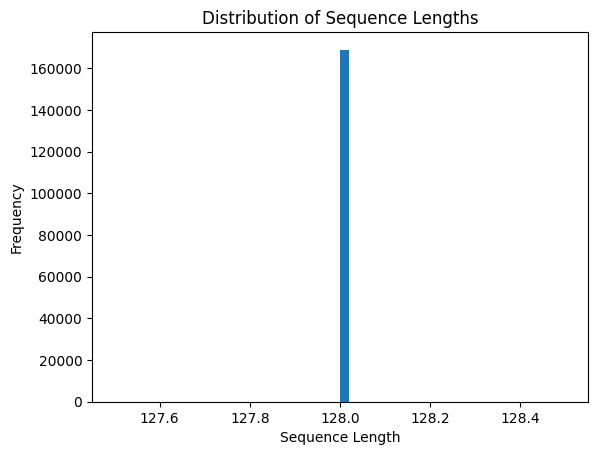

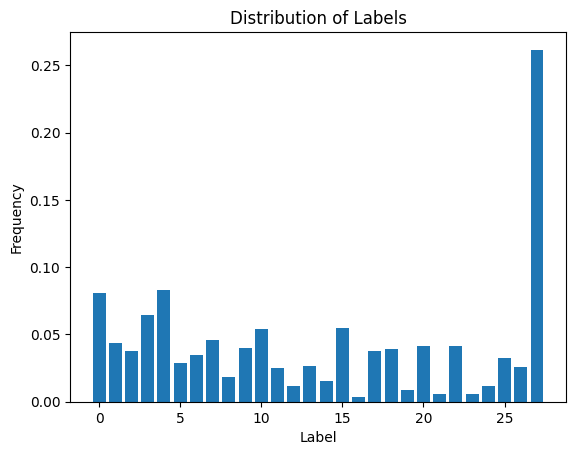

Average sequence length: 128.00
Standard deviation of sequence length: 0.00
Label frequencies: [0.0810798  0.04389799 0.03777407 0.06454402 0.08333037 0.02858226
 0.03475948 0.0456333  0.01812895 0.04012532 0.05413217 0.0250998
 0.01170297 0.02662781 0.01519136 0.05491395 0.00318041 0.03782737
 0.03897042 0.00874762 0.0414579  0.00608839 0.04158227 0.00602324
 0.01177404 0.03222463 0.02615401 0.26171778]


In [37]:
analyze_dataset(train_dataset)